In [161]:
import os
import tensorflow as tf
from tensorflow.keras import Sequential,layers,Input,optimizers
import kaggle
from PIL import Image
import glob
import numpy as np
import shutil
import matplotlib.pyplot as plt
import hashlib

In [2]:
# Download latest version
raw_data_path = "/Users/gechen/code/Gechen989898/AI_Art_vs_Human_Art/raw_data"
if os.path.exists(raw_data_path) and len(os.listdir(raw_data_path)) > 1:
    print(f'Datasets already downloaded ')
else:
    kaggle.api.dataset_download_files(
        "yangsangtai/tiny-genimage",
        path="/Users/gechen/code/Gechen989898/AI_Art_vs_Human_Art/raw_data",
        unzip=True
    )

Datasets already downloaded 


In [3]:
datasets = os.listdir(raw_data_path)
available_datasets = []
for dataset in datasets:
   train_path= os.path.join(raw_data_path,dataset,"train")
   if os.path.exists(train_path):
       available_datasets.append(dataset)
   else:
       print(f"{dataset} is available")

print(f"There are {len(available_datasets)} datasets available.")
print(f"they are {available_datasets}")

.DS_Store is available
There are 7 datasets available.
they are ['imagenet_glide', 'imagenet_midjourney', 'imagenet_ai_0424_wukong', 'imagenet_ai_0508_adm', 'imagenet_ai_0424_sdv5', 'imagenet_ai_0419_vqdm', 'imagenet_ai_0419_biggan']


In [4]:
picture_path = os.path.join(raw_data_path,"imagenet_ai_0419_biggan","train","ai","000_biggan_00093.png")
img = Image.open(picture_path)
img.verify
width, height = img.size
img_array  = np.array(img)
std_pic = np.std(img_array)
std_pic
width

128

In [ ]:
# step 1 : check if picturea are valid
def check_image_valid(image_path):
    try:
        img = Image.open(image_path)
        # check if the image is valid
        img.verify()
        img = Image.open(image_path)
        # conver image to RGB
        img = img.convert(mode="RGB")
        # check the size of image
        width,height = img.size
        if width <32 or height <32:
            print(f"This picture :{image_path} is too samll")
            return False
        # check the content of image
        img_array = np.array(img)
        if np.std(img_array)<1 :
            print(f"This picture :{image_path} has no content")
            return False
        return True
    except Exception as e:
        print(str(e))
        return False


In [6]:
# step 2 : clean the raw datasets
def clean_datasets(base_path,dataset_name):

    stats = {
    "total": 0,
    "valid" : 0,
    "invalid": 0,
    'removed': []
    }
    dataset_path = os.path.join(base_path,dataset_name)

    for split in ['train','val']:
        split_path = os.path.join(dataset_path,split)
        if not os.path.exists(split_path):
            continue
        for class_name in ['ai','nature']:
            class_path = os.path.join(split_path,class_name)
            if not os.path.exists(class_path):
                continue
            print(f"We are checking {dataset_path}/{split}/{class_name}")

            # check all the pictures of current directory

            image_files = [f for f in os.listdir(class_path)]

            for image_file in image_files:
                image_path = os.path.join(class_path,image_file)
                stats['total']+=1
                status = check_image_valid(image_path)
                if status == True:
                    stats['valid'] +=1
                else:
                    stats['invalid']+=1
                    stats['removed'].append(f"{image_file}")
                    try:
                        # os.remove(image_path)
                        print(f"{image_path} is invalid")
                    except Exception as e:
                        print(f"{image_path} cannot be removed")

    print(f"Stats :")
    print(f"There are total {stats['total']} pictures")
    print(f"There are {stats['valid']} valid pictures")
    print(f"There are {stats['invalid']} invalid pictures")
    return stats

In [7]:
all_stats = {}
for dataset in available_datasets:
    all_stats[dataset] = clean_datasets(raw_data_path,dataset)

We are checking /Users/gechen/code/Gechen989898/AI_Art_vs_Human_Art/raw_data/imagenet_glide/train/ai
We are checking /Users/gechen/code/Gechen989898/AI_Art_vs_Human_Art/raw_data/imagenet_glide/train/nature
We are checking /Users/gechen/code/Gechen989898/AI_Art_vs_Human_Art/raw_data/imagenet_glide/val/ai
We are checking /Users/gechen/code/Gechen989898/AI_Art_vs_Human_Art/raw_data/imagenet_glide/val/nature
Stats :
There are total 4999 pictures
There are 4999 valid pictures
There are 0 invalid pictures
We are checking /Users/gechen/code/Gechen989898/AI_Art_vs_Human_Art/raw_data/imagenet_midjourney/train/ai
We are checking /Users/gechen/code/Gechen989898/AI_Art_vs_Human_Art/raw_data/imagenet_midjourney/train/nature
We are checking /Users/gechen/code/Gechen989898/AI_Art_vs_Human_Art/raw_data/imagenet_midjourney/val/ai
We are checking /Users/gechen/code/Gechen989898/AI_Art_vs_Human_Art/raw_data/imagenet_midjourney/val/nature
Stats :
There are total 5000 pictures
There are 5000 valid pictures

In [8]:
all_stats

{'imagenet_glide': {'total': 4999, 'valid': 4999, 'invalid': 0, 'removed': []},
 'imagenet_midjourney': {'total': 5000,
  'valid': 5000,
  'invalid': 0,
  'removed': []},
 'imagenet_ai_0424_wukong': {'total': 5000,
  'valid': 5000,
  'invalid': 0,
  'removed': []},
 'imagenet_ai_0508_adm': {'total': 5000,
  'valid': 5000,
  'invalid': 0,
  'removed': []},
 'imagenet_ai_0424_sdv5': {'total': 5000,
  'valid': 5000,
  'invalid': 0,
  'removed': []},
 'imagenet_ai_0419_vqdm': {'total': 5000,
  'valid': 5000,
  'invalid': 0,
  'removed': []},
 'imagenet_ai_0419_biggan': {'total': 5000,
  'valid': 5000,
  'invalid': 0,
  'removed': []}}

In [10]:
def get_image_hash(image_path):
    """
    Calculate the hash value
    """
    try:
        with open(image_path, 'rb') as f:
            return hashlib.md5(f.read()).hexdigest()
    except:
        return None

In [ ]:
# step 3 : Remove duplicates picture
# TODO : need to be completed
seen_hash = {}
duplicates = []
for dataset in available_datasets:
    dataset_path = os.path.join(raw_data_path,dataset)
    print(dataset_path)
    if not os.path.exists(dataset_path):
        continue
    for split in ["train","val"]:
        for class_name in ["ai","nature"]:
            class_path = os.path.join(dataset_path,split,class_name)
            if not os.path.exists(class_path):
                continue
            for img_file in os.listdir(class_path):
                if not img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
                    continue
                image_path = os.path.join(class_path,img_file)
                image_hash = get_image_hash(image_path)
                print(image_hash)
                # TODO: need to modify this part that can remove duplciate by using hash

In [ ]:
# step 4 : Merge cleanned dataset to a new folder
# create the directories
merged_path = 'merged_data'
merged_train_path = os.path.join(merged_path, 'train')
merged_val_path = os.path.join(merged_path, 'val')
for split in ['train', 'val']:
    for class_name in ['ai', 'nature']:
        os.makedirs(os.path.join(merged_path, split, class_name), exist_ok=True)

In [ ]:
def merge_clean_datasets(dataset,base_path,merged_path):

    stats = {
    'train':{'ai':0, 'nature':0},
    'val':{'ai':0,'nature':0}
    }
    # fdfd
    for dataset in available_datasets:
        dataset_path = os.path.join(base_path,dataset)
        if not os.path.exists(dataset_path):
            continue
        for split in ['train','val']:
            split_path = os.path.join(dataset_path,split)
            if not os.path.exists(split_path):
                continue
            for class_name in ['ai','nature']:
                class_path = os.path.join(split_path,class_name)
                if not os.path.exists(class_path):
                    continue

                target_path = os.path.join(merged_path,split,class_name)
                copied = 0
                for img_file in os.listdir(class_path):
                    if img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
                        src_file = os.path.join(class_path, img_file)
                        dst_file = os.path.join(target_path, img_file)
                        if os.path.exists(dst_file):
                            continue

                        shutil.copy2(src_file,dst_file)
                        copied += 1
                        stats[split][class_name] += 1
    print(stats)
    return stats

In [ ]:
# merge datasets to target directory
for dataset in available_datasets:
   merge_stats =  merge_clean_datasets(dataset,raw_data_path,merged_path)

{'train': {'ai': 0, 'nature': 0}, 'val': {'ai': 0, 'nature': 0}}
{'train': {'ai': 0, 'nature': 0}, 'val': {'ai': 0, 'nature': 0}}
{'train': {'ai': 0, 'nature': 0}, 'val': {'ai': 0, 'nature': 0}}
{'train': {'ai': 0, 'nature': 0}, 'val': {'ai': 0, 'nature': 0}}
{'train': {'ai': 0, 'nature': 0}, 'val': {'ai': 0, 'nature': 0}}
{'train': {'ai': 0, 'nature': 0}, 'val': {'ai': 0, 'nature': 0}}
{'train': {'ai': 0, 'nature': 0}, 'val': {'ai': 0, 'nature': 0}}


In [38]:
# step 5 : Load dataset
img_size = (128, 128)
batch_size = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
    merged_train_path,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='binary',
    seed=42

)

val_ds = tf.keras.utils.image_dataset_from_directory(
    merged_val_path,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='binary',
    seed=42
)


Found 27999 files belonging to 2 classes.
Found 7000 files belonging to 2 classes.


In [39]:
# TODO: data augmentation, AUTOTUNE, prefetch

In [40]:
train_ds.class_names

['ai', 'nature']

In [41]:
normalize = layers.Rescaling(1./255)

In [42]:
train_ds = train_ds.map(
    lambda x , y : (normalize(x),y)
)

In [43]:
train_ds

<_MapDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>

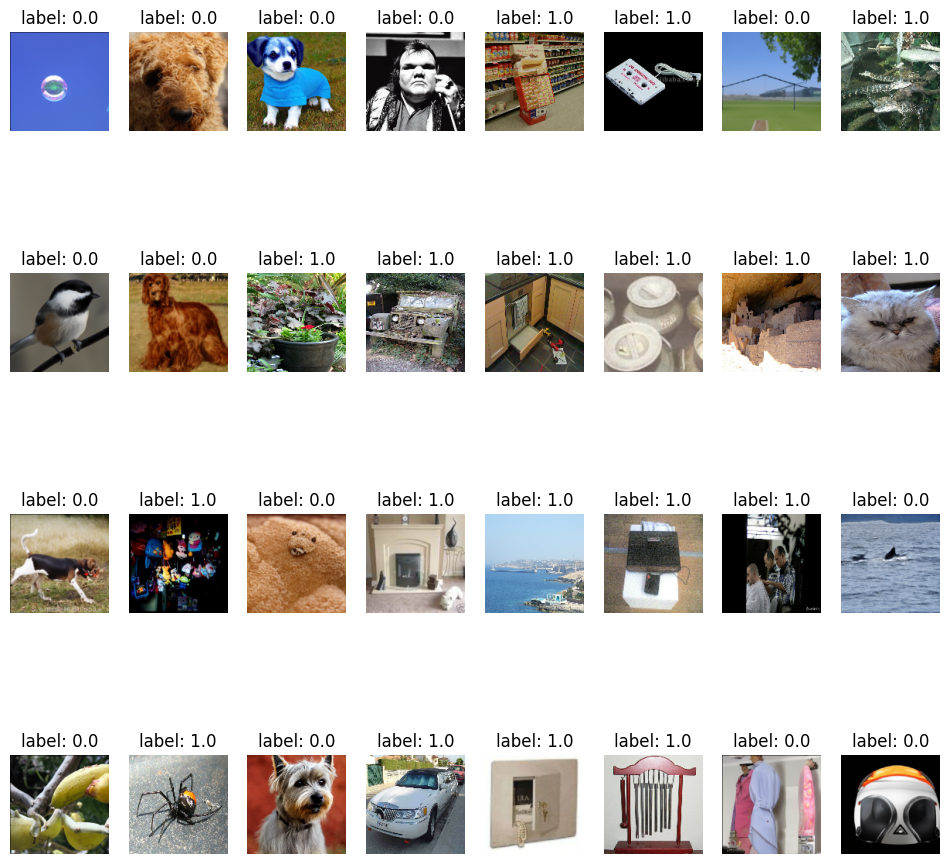

2026-02-10 20:02:00.096826: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [44]:

for images, labels in train_ds.take(1):
    batch_size = images.shape[0]

    plt.figure(figsize=(12, 12))
    for i in range(batch_size):
        plt.subplot(4, 8, i + 1)  #
        plt.imshow(images[i].numpy())
        plt.title(f"label: {labels[i].numpy()[0]}")
        plt.axis("off")
    plt.show()

In [45]:
val_ds = val_ds.map(
    lambda x , y : (normalize(x),y)
)

In [46]:
val_ds

<_MapDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>

In [47]:
model = Sequential()

model.add(Input((128, 128, 3)))
model.add(layers.Conv2D(filters = 32, kernel_size = (3,3), activation="relu", padding="same"))
model.add(layers.MaxPooling2D(pool_size=(2, 2), padding="same") )
#TODO:Dropout layer
model.add(layers.Conv2D(filters = 32, kernel_size = (3,3), activation="relu", padding="same"))
model.add(layers.MaxPooling2D(pool_size=(2, 2), padding="same") )
#TODO:Dropout layer
model.add(layers.Conv2D(filters = 64, kernel_size = (3,3), activation="relu", padding="same"))
model.add(layers.MaxPooling2D(pool_size=(2, 2), padding="same") )
#TODO:Dropout layer
model.add(layers.Conv2D(filters = 128, kernel_size = (3,3), activation="relu", padding="same"))
model.add(layers.MaxPooling2D(pool_size=(2, 2), padding="same") )
#TODO:Dropout layer
model.add(layers.Flatten())
model.add(layers.Dense(64, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation="sigmoid"))
# And we perform the prediction using sigmoid

In [48]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 64, 64, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │       524,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 626,913 (2.39 MB)

 Trainable params: 626,913 (2.39 MB)

 Non-trainable params: 0 (0.00 B)

In [49]:
adam = optimizers.Adam(learning_rate = 0.001)
model.compile(loss='binary_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])

In [50]:
%%time
history_basic_cnn = model.fit(
        train_ds,
        epochs=20,
        validation_data=val_ds
        )

Epoch 1/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 141s 159ms/step - accuracy: 0.6570 - loss: 0.6153 - val_accuracy: 0.7669 - val_loss: 0.4970
Epoch 2/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 133s 152ms/step - accuracy: 0.7666 - loss: 0.5014 - val_accuracy: 0.8030 - val_loss: 0.4373
Epoch 3/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 133s 152ms/step - accuracy: 0.7942 - loss: 0.4551 - val_accuracy: 0.8074 - val_loss: 0.4266
Epoch 4/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 135s 154ms/step - accuracy: 0.8117 - loss: 0.4227 - val_accuracy: 0.8197 - val_loss: 0.4084
Epoch 5/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 135s 155ms/step - accuracy: 0.8251 - loss: 0.3904 - val_accuracy: 0.8244 - val_loss: 0.3915
Epoch 6/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 133s 152ms/step - accuracy: 0.8404 - loss: 0.3639 - val_accuracy: 0.8236 - val_loss: 0.4131
Epoch 7/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 134s 153ms/step - accuracy: 0.8530 - loss: 0.3344 - val_accuracy: 0.8370 - val_loss: 0.3921
Epoch 8/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 144s 164ms/step - accuracy: 0.8657 -

In [52]:
history_basic_cnn.history

{'accuracy': [0.656987726688385,
  0.7665988206863403,
  0.7942426800727844,
  0.8117432594299316,
  0.8251366019248962,
  0.8404228687286377,
  0.8530304431915283,
  0.8657451868057251,
  0.8814243078231812,
  0.893031895160675,
  0.8990678191184998,
  0.9143897891044617,
  0.9194614291191101,
  0.9270331263542175,
  0.9347476959228516,
  0.9396764039993286,
  0.9407121539115906,
  0.9483195543289185,
  0.9439979791641235,
  0.9518554210662842],
 'loss': [0.6153174042701721,
  0.5014333128929138,
  0.4550657570362091,
  0.42274731397628784,
  0.3903806507587433,
  0.3638765811920166,
  0.33442389965057373,
  0.31077736616134644,
  0.2778051495552063,
  0.2506275177001953,
  0.2312549352645874,
  0.20440275967121124,
  0.1945997178554535,
  0.1759021282196045,
  0.1605425924062729,
  0.14742033183574677,
  0.14504148066043854,
  0.12998737394809723,
  0.1360636204481125,
  0.12094490975141525],
 'val_accuracy': [0.7668571472167969,
  0.8029999732971191,
  0.8074285984039307,
  0.819714

In [62]:
def plot_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].set_title('loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[1].set_title('accuracy')
    ax[1].plot(history.epoch, history.history["accuracy"], label="Train acc")
    ax[1].plot(history.epoch, history.history["val_accuracy"], label="Validation acc")
    ax[0].legend()
    ax[1].legend()


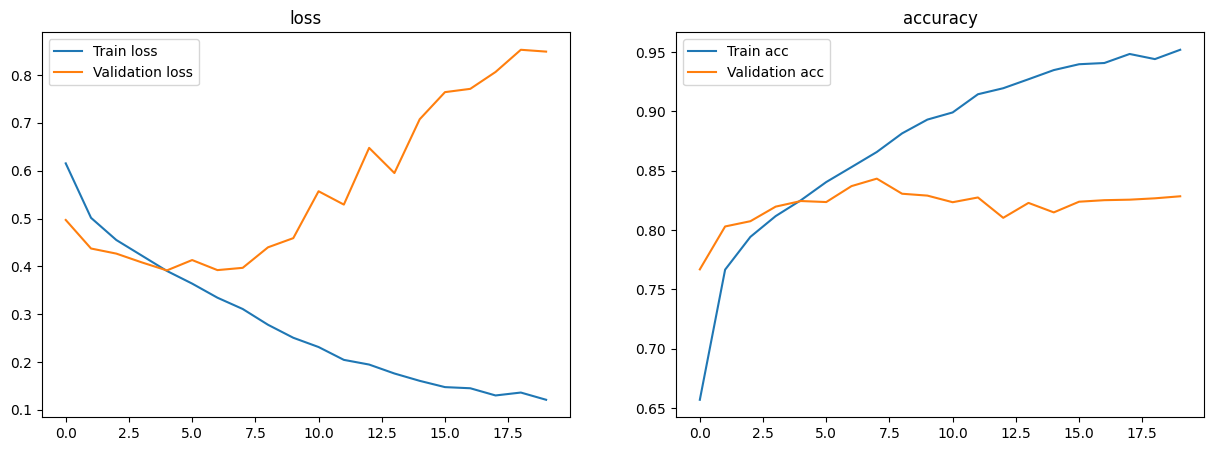

In [63]:
plot_history(history_basic_cnn)

In [37]:
# Compare the performance of 2 models
def plot_compare_history(history, name_history, history_1, name_history_1):

    fig, ax = plt.subplots(1, 2, figsize=(15,5))

    ax[0].set_title('loss')

    ax[0].plot(history.epoch, history.history["loss"], label="Train loss " + name_history)
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss " + name_history)

    ax[0].plot(history_1.epoch, history_1.history["loss"], label="Train loss " + name_history_1)
    ax[0].plot(history_1.epoch, history_1.history["val_loss"], label="Validation loss " + name_history_1)

    ax[1].set_title('Accuracy')

    ax[1].plot(history.epoch, history.history["accuracy"], label="Train Accuracy " + name_history)
    ax[1].plot(history.epoch, history.history["val_accuracy"], label="Validation Accuracy " + name_history)

    ax[1].plot(history_1.epoch, history_1.history["accuracy"], label="Train Accuracy " + name_history_1)
    ax[1].plot(history_1.epoch, history_1.history["val_accuracy"], label="Validation Accuracy " + name_history_1)

    ax[0].legend()
    ax[1].legend()

In [70]:
model.save("basic_cnn.keras")

In [82]:
cat = "https://www.wikichat.fr/wp-content/uploads/sites/2/comment-soigner-une-plaie-dun-chat.jpg"
cat2 = "http://create.votreveterinaire.com/adm/webmaster/_empty/upload/chat_surpris.jpg"


dog = "https://images.sudouest.fr/2018/04/14/5ace461a66a4bd2b1780a0dd/widescreen/1000x500/on-ignore-si-le-chihuahua-a-deserte-ou-non-les-locaux-de-la-clinique.jpg?v1"
dog2 = "https://ds1.static.rtbf.be/article/image/370x208/7/8/f/a20f02dfccd07952da54a7f9a82b3e89-1524657315.jpg"

In [157]:
import requests
from io import BytesIO

def get_image(url):
    response = requests.get(url=url)
    img = Image.open(BytesIO(response.content))
    img = img.convert(mode="RGB")
    img = img.resize(img_size)
    print(f"picture size : {img_size}; mode : {img.mode}")
    return img


In [158]:
from keras.preprocessing.image import array_to_img, img_to_array, load_img

def image_predict(url,model):
    img = get_image(url)
    img_array = img_to_array(img)
    img_array = img_array.reshape((1, 128, 128, 3))
    img_array = img_array / 255.0
    prediction = model.predict(img_array)
    result = round(prediction[0][0],2)
    plt.imshow(img)
    plt.axis('off')
    if result<0.5:
        print("The picture is AI generated")
    if result>=0.5:
        print("The picture is not AI generated")

picture size : (128, 128); mode : RGB
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
The picture is not AI generated


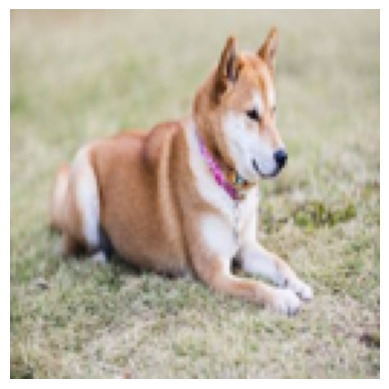

In [159]:
image_predict(dog2,model)

picture size : (128, 128); mode : RGB
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
The picture is AI generated


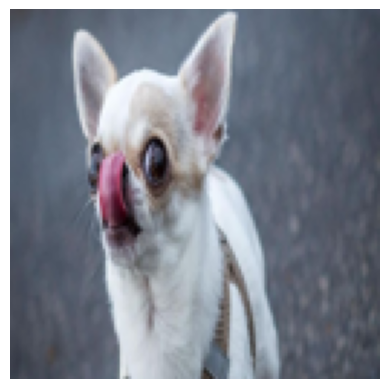

In [160]:
image_predict(dog,model)